In [1]:
import pandas as pd
pd.options.display.width = 120

In [2]:
DATA_DIR = ('https://gitlab.com/tangibleai/nlpia/'
            '-/raw/master/src/nlpia/data')

url = DATA_DIR + '/toxic_comment_small.csv'

comments = pd.read_csv(url)
index = [f'comment {i},{"!"*j}' for (i,j) in zip(range(len(comments)), comments.toxic)]
comments = pd.DataFrame(comments.values, columns=comments.columns, index=index)
mask = comments.toxic.astype(bool).values
comments['toxic'] = comments.toxic.astype(int)
len(comments)

5000

In [3]:
comments

,text,toxic
"comment 0,",you have yet to identify where my edits violat...,0
"comment 1,","""\n as i have already said,wp:rfc or wp:ani. (...",0
"comment 2,",your vote on wikiquote simple english when it ...,0
"comment 3,",your stalking of my edits i've opened a thread...,0
"comment 4,!",straight from the smear site itself. the perso...,1
...,...,...
"comment 4995,","""\nyeah, sorry about that. i didn't look clos...",0
"comment 4996,","""hmm, interesting.. oh, why would i make fun o...",0
"comment 4997,!","""put up or shut up\nto all you people who thin...",1
"comment 4998,!",this is your last warning \nim warning u respo...,1


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
nlp = spacy.load("en_core_web_sm")

def spacy_tokenize(sentence):
    return [token.text for token in nlp(sentence.lower())]

tfidf_model = TfidfVectorizer(tokenizer=spacy_tokenize)
tfidf_docs = tfidf_model.fit_transform(\
    raw_documents=comments.text).toarray()

tfidf_docs.shape

C:\Users\oo_wa\.conda\envs\nlpia2\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5000, 19160)

## Manual Prediction

In [6]:
# import re 
# import string
# pattern = r'\w+ '
# all_tokens = []
# for each_sentence in comments.text:
#     all_tokens.extend(re.findall(pattern, str(each_sentence)))

# len(all_tokens)

# vocab = set(all_tokens)
# print(len(vocab))

In [7]:
mask = comments.toxic.astype(bool).values  # <1>
toxic_centroid = tfidf_docs[mask].mean(axis=0)  # <2>
nontoxic_centroid = tfidf_docs[~mask].mean(axis=0)  # <3>

In [8]:
# toxic_centroid

In [9]:
# display(pd.DataFrame(tfidf_docs[mask]).mean(axis=0))

In [10]:
# display(pd.DataFrame(tfidf_docs[mask][649]).mean(axis=0))
# display(pd.DataFrame(tfidf_docs[mask][649]).mean())

In [11]:
centroid_axis = toxic_centroid - nontoxic_centroid
toxicity_score = tfidf_docs.dot(centroid_axis)  # <1>
toxicity_score.round(3)

array([-0.008, -0.022, -0.014, ..., -0.025, -0.001, -0.022])

In [26]:
# centroid_axis.shape
# toxic_centroid.shape
#toxicity_score.shape

In [12]:
from sklearn.preprocessing import MinMaxScaler
comments['manual_score'] = MinMaxScaler().fit_transform(\
    toxicity_score.reshape(-1,1))
comments['manual_predict'] = (comments.manual_score > .5).astype(int)
comments['toxic manual_predict manual_score'.split()].round(2).head(6)

,toxic,manual_predict,manual_score
"comment 0,",0,0,0.41
"comment 1,",0,0,0.27
"comment 2,",0,0,0.35
"comment 3,",0,0,0.47
"comment 4,!",1,0,0.48
"comment 5,",0,0,0.31


In [30]:
#comments['manual_predict'].value_counts()
#'toxic manual_predict manual_score'.split()

In [13]:
#(1-(actual_y - predicted_y).abs().sum()/len(comments))
#(1 - (error))
(1 - (comments.toxic - comments.manual_predict).abs().sum() / len(comments))

0.8944

## LDA Prediction

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda_tfidf = LDA(n_components=1)
#lda_tfidf = lda_tfidf.fit(x_train, y_train)
lda_tfidf = lda_tfidf.fit(tfidf_docs, comments['toxic'])
#comments['tfidf_predict'] = lda_tfidf.predict(x_train)
comments['tfidf_predict'] = lda_tfidf.predict(tfidf_docs)
round(float(lda_tfidf.score(tfidf_docs, comments['toxic'])))

1

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tfidf_docs,\
    comments.toxic.values, test_size=0.5, random_state=271828)
lda_tfidf = LDA(n_components=1)
lda = lda_tfidf.fit(X_train, y_train)  # <1>
round(float(lda.score(X_train, y_train)), 3) #score on training data

0.999

In [16]:
round(float(lda.score(X_test, y_test)), 3) #score on validation data

0.555

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, lda.predict(X_test))

array([[1265,  909],
       [ 204,  122]], dtype=int64)

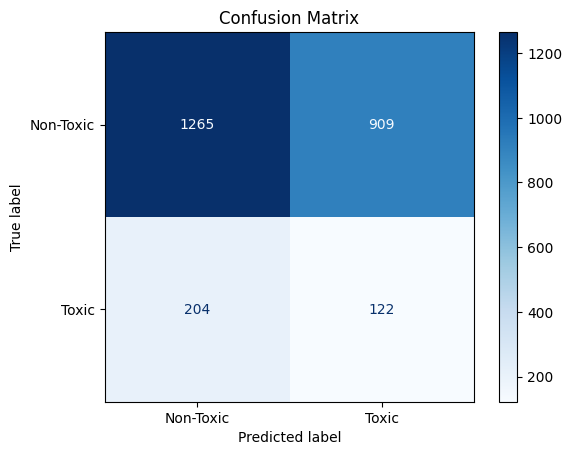

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, lda.predict(X_test))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non-Toxic', 'Toxic'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()